In [1]:
!pip install pyparsing==2.4.6

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import sys
sys.path.append("../utils/") 
from utilities import performance_metrics
import time

from src.core import Term, Atom
from src.ilp import Language_Frame, Program_Template, Rule_Template
from src.dilp import DILP
import tensorflow as tf
import numpy as np
from src.utils import process_file, process_dir, output_rules, test_rule, create_table
from src.generate_template import create_templates
import duckdb
tf.random.set_seed(1000)


2024-05-16 13:55:52.091838: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 13:55:53.171865: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
con = duckdb.connect(':memory:')
# enable automatic query parallelization
con.execute("PRAGMA threads=2")
# enable caching of parquet metadata
con.execute("PRAGMA enable_object_cache")

In [4]:
def train(dilp):
    start_time = time.time()
    dilp.train()
    finish_time = time.time()
    print("execution time %d" % (finish_time - start_time))
def test(dilp):
    rules = dilp.show_definition()
    sql_str = output_rules(rules)
    predicted_table = test_rule(con, sql_str, target_predicate="Target")
    performance_metrics(predicted_table["Target"], input_table["Target"], labels=[True,False])
    return sql_str

## Rule template
 Rule_Template(v: int, allow_intensional: bool): 
v is number of existentially qualified variables(X,Y,Z...) in the clause

Program_Template(p_a: list, rules: dict, T: int):
 p_a {list} -- set of auxiliary predicates; these are the additional invented predicates used to help define the target predicate
 
 
 rules {tuple} -- Map of intensional predicate to a pair if rule templates 
 T {int} -- Max number of steps of forward chaining inference

## a, b, c, d learning

In [5]:
%%time 
input_dir = '../examples/a-b-c-d/'
input_table = create_table(con, input_dir)
print(f'ratio of positives %f' % (100*input_table['Target'].sum()/len(input_table)))

target, p_e, constants, B, P, N = process_dir(input_dir)

# arity 1
term_x_0 = Term(True, 'X_0')
p_a, rules = create_templates(p_e, target, term_x_0)

# target_rule = (Rule_Template(v=0, allow_intensional=False), None)
# rules = {target: target_rule} 

language_frame = Language_Frame(target, p_e, constants)

ratio of positives 7.000000
206
end of facts processing
7
end of positive examples processing
86
end negative examples processing
data is in order
CPU times: user 132 ms, sys: 31 µs, total: 132 ms
Wall time: 133 ms


In [6]:
print(*zip(rules.keys(), map(lambda x: (x[0].v, x[0].allow_intensional), list(rules.values()))))

(pred1(X_0), (0, True)) (pred2(X_0), (0, False)) (Target(X_0), (0, True))


Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 0.15538237988948822
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Target(18) Expected: 0 0.001
Target(13) Expected: 1 0.491
Target(37) Expected: 0 0.111
Target(38) Expected: 0 0.029
Target(32) Expected: 0 0.304
Target(57) Expected: 0 0.005
Target(74) Expected: 0 0.026
Target(60) Expected: 0 0.320
Target(35) Expected: 0 0.069
Target(99) Expected: 0 0.320
Target(75) Expected: 0 0.005
Target(45) Expected: 0 0.029
Target(36) Expected: 0 0.024
Target(69) Expected: 0 0.138
Target(46) Expected: 0 0.005
Target(54) Expected: 0 0.054
Target(89) Expected: 0 0.069
Target(6) Expected: 0 0.003
Target(61) Expected: 0 0.003
Target(51) Expected: 0 0.054
Target(9

'select D and C as pred2,\n Target and C as pred1,\n B and pred2 as Target,\n'

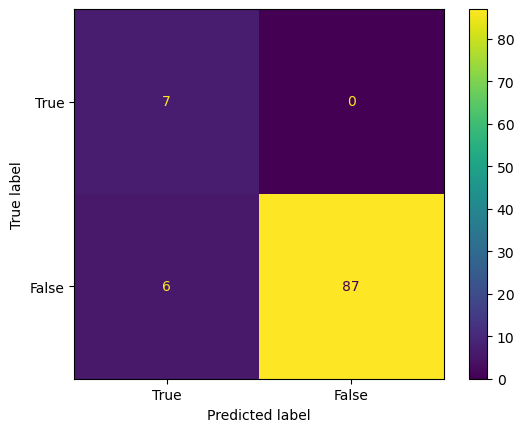

In [7]:
T=2
program_template = Program_Template(p_a, rules, T=T)
dilp = DILP(language_frame, B, P, N, program_template, allow_target_recursion=True)
train(dilp)
test(dilp)

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 0.3657246232032776
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Target(18) Expected: 0 0.003
Target(13) Expected: 1 0.915
Target(37) Expected: 0 0.783
Target(38) Expected: 0 0.287
Target(32) Expected: 0 0.439
Target(57) Expected: 0 0.011
Target(74) Expected: 0 0.313
Target(60) Expected: 0 0.523
Target(35) Expected: 0 0.177
Target(99) Expected: 0 0.523
Target(75) Expected: 0 0.011
Target(45) Expected: 0 0.287
Target(36) Expected: 0 0.229
Target(69) Expected: 0 0.428
Target(46) Expected: 0 0.011
Target(54) Expected: 0 0.039
Target(89) Expected: 0 0.177
Target(6) Expected: 0 0.052
Target(61) Expected: 0 0.052
Target(51) Expected: 0 0.039
Target(9)

'select D and B as pred2,\n C and pred2 as pred1,\n A and pred1 as Target,\n'

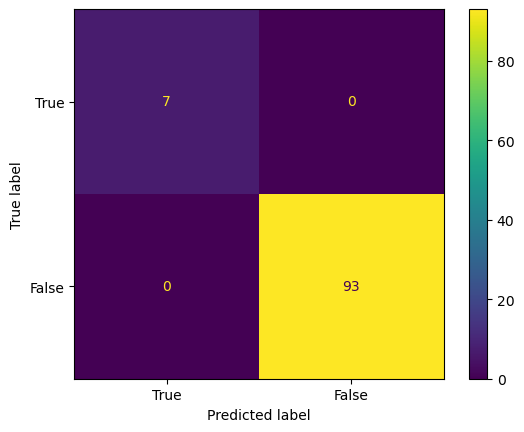

In [8]:
T=3
program_template = Program_Template(p_a, rules, T=T)
dilp = DILP(language_frame, B, P, N, program_template, allow_target_recursion=True)
train(dilp)
test(dilp)

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 1.3212230205535889
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Target(18) Expected: 0 0.077
Target(13) Expected: 1 1.000
Target(37) Expected: 0 0.931
Target(38) Expected: 0 0.492
Target(32) Expected: 0 0.942
Target(57) Expected: 0 0.029
Target(74) Expected: 0 0.379
Target(60) Expected: 0 0.928
Target(35) Expected: 0 0.780
Target(99) Expected: 0 0.928
Target(75) Expected: 0 0.029
Target(45) Expected: 0 0.492
Target(36) Expected: 0 0.705
Target(69) Expected: 0 0.987
Target(46) Expected: 0 0.029
Target(54) Expected: 0 0.778
Target(89) Expected: 0 0.780
Target(6) Expected: 0 0.184
Target(61) Expected: 0 0.184
Target(51) Expected: 0 0.778
Target(9)

'select D and A as pred2,\n B and pred2 as pred1,\n C and pred1 as Target,\n'

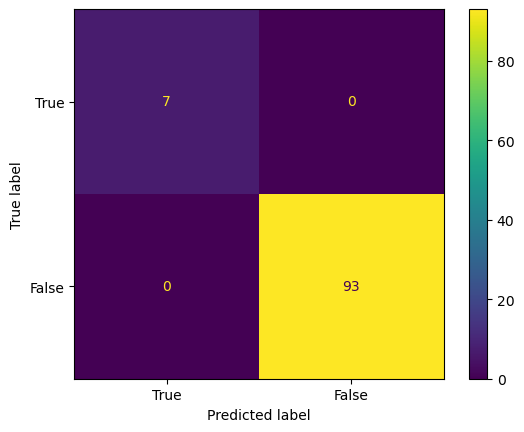

In [9]:
T=5
program_template = Program_Template(p_a, rules, T=T)
dilp = DILP(language_frame, B, P, N, program_template, allow_target_recursion=True)
train(dilp)
test(dilp)

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 4.73201322555542
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Target(18) Expected: 0 0.523
Target(13) Expected: 1 1.000
Target(37) Expected: 0 0.999
Target(38) Expected: 0 0.966
Target(32) Expected: 0 1.000
Target(57) Expected: 0 0.315
Target(74) Expected: 0 0.988
Target(60) Expected: 0 1.000
Target(35) Expected: 0 0.977
Target(99) Expected: 0 1.000
Target(75) Expected: 0 0.315
Target(45) Expected: 0 0.966
Target(36) Expected: 0 0.906
Target(69) Expected: 0 1.000
Target(46) Expected: 0 0.315
Target(54) Expected: 0 0.992
Target(89) Expected: 0 0.977
Target(6) Expected: 0 0.288
Target(61) Expected: 0 0.288
Target(51) Expected: 0 0.992
Target(9) E

'select B and A as pred2,\n Target and C as pred1,\n D and pred1 as Target,\n'

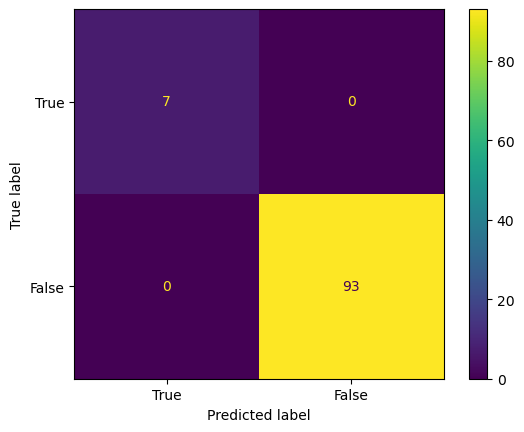

In [10]:
T=10
program_template = Program_Template(p_a, rules, T=T)
dilp = DILP(language_frame, B, P, N, program_template, allow_target_recursion=True)
train(dilp)
test(dilp)

Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
--------------------
step 0 loss is 5.994785308837891
Performing Inference
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Inference Complete
Target(18) Expected: 0 0.481
Target(13) Expected: 1 1.000
Target(37) Expected: 0 1.000
Target(38) Expected: 0 0.984
Target(32) Expected: 0 1.000
Target(57) Expected: 0 0.047
Target(74) Expected: 0 0.994
Target(60) Expected: 0 1.000
Target(35) Expected: 0 0.999
Target(99) Expected: 0 1.000
Target(75) Expected: 0 0.047
Target(45) Expected: 0 0.984
Target(36) Expected: 0 0.999
Target(69) Expected: 0 1.000
Target(46) Expected: 0 0.047
Target(54) Expected: 0 0.995
Target(89) Expected: 0 0.999
Target(6) Expected: 0 0.937
Target(61) Expected: 0 0.937
Target(51) Expected: 0 0.995
Target(9) 

'select C and A as pred2,\n B and pred2 as pred1,\n D and pred1 as Target,\n'

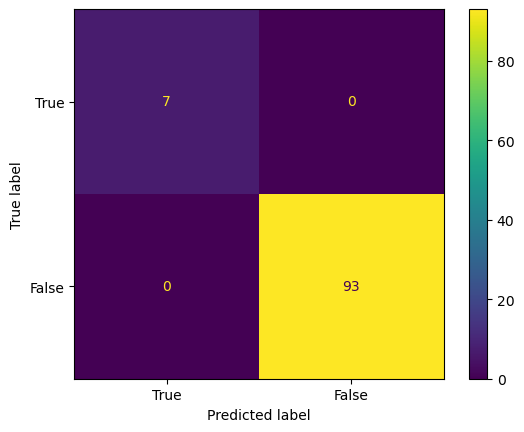

In [11]:
T=10
program_template = Program_Template(p_a, rules, T=T)
dilp = DILP(language_frame, B, P, N, program_template, allow_target_recursion=False)
train(dilp)
test(dilp)